# Variational Graph Autoencoder

The variational graph autoencoder is our second GNN for link prediction. As opposed to the heuristics and latent-feature methods which serve as our baselines, it is capable of taking into account both the graph structure and the node features to predict links correctly.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
import seaborn as sns

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf')

import ipynb
from ipynb.fs.defs.dataset_creation import LinkPredictionDataset

import json
import os
import os.path as osp
import time

from sklearn.linear_model import LogisticRegression

import torch
import torch.nn.functional as F
import torch_geometric
from torch_geometric.nn import VGAE, GCNConv 
from torch_geometric.data import Data
from torch_geometric.data import Dataset, download_url
from torch_geometric.transforms import RandomLinkSplit 

#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_columns', None)

## Define helper functions

In [2]:
def mean(dict_values):
    """
    Get mean of dictionary values.
    """
    return np.mean(np.array(list(dict_values)))

In [3]:
def std(dict_values):
    """
    Get standard deviation of dictionary values.
    """
    return np.std(np.array(list(dict_values)))

In [2]:
def filter_best_hyperparameters(df, variable):
    """
    Filter the results data frame for the best hyperparameter combination(s).
    """
    return df[df[variable] == df[variable].max()]

In [5]:
def print_best_hyperparameters(df, variable):
    """
    Print best hyperparameter combination(s).
    """
    df_best = df[df[variable] == df[variable].max()]
    print('The best hyperparameter combination/s is/are:\n\t',
          '\n\t '.join([str(df_best['parameters'].iloc[i]) for i in range(len(df_best))]),
          '\nThe resulting mean best validation average precision is:', df_best[variable].unique()[0])

In [6]:
def model_summary(model): 
    """
    Get a summary of the neural network/graph neural network.
    """
    model_params_list = list(model.named_parameters())
    print("--------------------------------------------------------------------------")
    line_new = "{:>30}  {:>25} {:>15}".format("Layer.Parameter", "Param Tensor Shape", "Param #")
    print(line_new)
    print("--------------------------------------------------------------------------")
    for elem in model_params_list:
        p_name = elem[0] 
        p_shape = list(elem[1].size())
        p_count = torch.tensor(elem[1].size()).prod().item()
        line_new = "{:>30}  {:>25} {:>15}".format(p_name, str(p_shape), str(p_count))
        print(line_new)
    print("--------------------------------------------------------------------------")
    total_params = sum([param.nelement() for param in model.parameters()])
    print("Total params:", total_params)
    num_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print("Trainable params:", num_trainable_params)
    print("Non-trainable params:", total_params - num_trainable_params)

In [7]:
def plot_losses_and_accuracies(plot_type, df, index, spacing, filename, save):
    """
    Create the data frames required for plotting the losses and accuracies.
    """
    sns.set_style("whitegrid")  
    
    epoch_1, epoch_2, epoch_3, epoch_4, epoch_5, epoch_6, epoch_7, epoch_8, epoch_9, epoch_10 = 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
    epochs = [epoch_1, epoch_2, epoch_3, epoch_4, epoch_5, epoch_6, epoch_7, epoch_8, epoch_9, epoch_10]
    
    if plot_type == 'loss':
        loss_df_1, loss_df_2, loss_df_3, loss_df_4, loss_df_5, loss_df_6, loss_df_7, loss_df_8, loss_df_9, loss_df_10 = 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
        loss_df = [loss_df_1, loss_df_2, loss_df_3, loss_df_4, loss_df_5, loss_df_6, loss_df_7, loss_df_8, loss_df_9, loss_df_10]
        print_list = ['loss'] * 10
    elif plot_type == 'acc':
        acc_df_1, acc_df_2, acc_df_3, acc_df_4, acc_df_5, acc_df_6, acc_df_7, acc_df_8, acc_df_9, acc_df_10 = 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 
        acc_df = [acc_df_1, acc_df_2, acc_df_3, acc_df_4, acc_df_5, acc_df_6, acc_df_7, acc_df_8, acc_df_9, acc_df_10]
        print_list = ['acc'] * 10
    elif plot_type == 'ap':
        ap_df_1, ap_df_2, ap_df_3, ap_df_4, ap_df_5, ap_df_6, ap_df_7, ap_df_8, ap_df_9, ap_df_10 = 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 
        ap_df = [ap_df_1, ap_df_2, ap_df_3, ap_df_4, ap_df_5, ap_df_6, ap_df_7, ap_df_8, ap_df_9, ap_df_10]
        print_list = ['ap'] * 10
    elif plot_type == 'auc':
        auc_df_1, auc_df_2, auc_df_3, auc_df_4, auc_df_5, auc_df_6, auc_df_7, auc_df_8, auc_df_9, auc_df_10 = 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 
        auc_df = [auc_df_1, auc_df_2, auc_df_3, auc_df_4, auc_df_5, auc_df_6, auc_df_7, auc_df_8, auc_df_9, auc_df_10]
        print_list = ['auc'] * 10
    
    for i in range(len(epochs)):
        epochs[i] = [k for k in range(1, 1+len(df['train_losses'][index][f"{i+1}"]))]
    
        if plot_type == 'loss':
            loss_df[i] = pd.DataFrame(list(zip(epochs[i], df['train_losses'][index][f"{i+1}"], \
                                               df['val_losses'][index][f"{i+1}"], df['test_losses'][index][f"{i+1}"])), \
                                      columns = ['epoch', 'train_loss', 'val_loss', 'test_loss'])
            loss_df[i] = pd.melt(loss_df[i], id_vars=['epoch'], value_vars=['train_loss', 'val_loss', 'test_loss'])
        elif plot_type == 'acc':
            acc_df[i] = pd.DataFrame(list(zip(epochs[i], df['train_accs'][index][f"{i+1}"], \
                                              df['val_accs'][index][f"{i+1}"], df['test_accs'][index][f"{i+1}"])), \
                                     columns = ['epoch', 'train_acc', 'val_acc', 'test_acc'])
            acc_df[i] = pd.melt(acc_df[i], id_vars=['epoch'], value_vars=['train_acc', 'val_acc', 'test_acc'])
        elif plot_type == 'ap':
            ap_df[i] = pd.DataFrame(list(zip(epochs[i], df['train_aps'][index][f"{i+1}"], \
                                              df['val_aps'][index][f"{i+1}"], df['test_aps'][index][f"{i+1}"])), \
                                     columns = ['epoch', 'train_ap', 'val_ap', 'test_ap'])
            ap_df[i] = pd.melt(ap_df[i], id_vars=['epoch'], value_vars=['train_ap', 'val_ap', 'test_ap'])
        elif plot_type == 'auc':
            auc_df[i] = pd.DataFrame(list(zip(epochs[i], df['train_aucs'][index][f"{i+1}"], \
                                              df['val_aucs'][index][f"{i+1}"], df['test_aucs'][index][f"{i+1}"])), \
                                     columns = ['epoch', 'train_auc', 'val_auc', 'test_auc'])
            auc_df[i] = pd.melt(auc_df[i], id_vars=['epoch'], value_vars=['train_auc', 'val_auc', 'test_auc'])
        
    seeds = [12345, 23456, 34567, 45678, 56789, 54321, 65432, 76543, 87654, 98765]
    
    fig1, fig2, fig3, fig4, fig5, fig6, fig7, fig8, fig9, fig10 = 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
    figs = [fig1, fig2, fig3, fig4, fig5, fig6, fig7, fig8, fig9, fig10]
    fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(16,24))
    
    axes_list = [axes[0,0], axes[0,1], axes[1,0], axes[1,1], axes[2,0], axes[2,1], axes[3,0], axes[3,1], axes[4,0], axes[4,1]]
    
    for j, seed in enumerate(seeds):
        if plot_type == 'loss':
            data = loss_df[j]
        elif plot_type == 'acc':
            data = acc_df[j]
        elif plot_type == 'ap':
            data = ap_df[j]
        elif plot_type == 'auc':
            data = auc_df[j]
        figs[j] = sns.lineplot(data=data, x="epoch", y="value", hue="variable", ax=axes_list[j]).set_title(f"Run {j + 1} with seed {seeds[j]}: {print_list[j]}/epoch", fontsize=16)
        axes_list[j].xaxis.set_major_locator(MultipleLocator(spacing))
    
    plt.tight_layout()
        
    if save:
        plt.savefig(f"./plots/{filename}.svg", bbox_inches='tight') 

## Hyperparameter tuning

We use the [PyTorch Geometric implementation](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.models.VGAE) of a variational graph autoencoder `VGAE`. 

With VGAEs, the main hyperparameters to tune are:
* `hidden_channels`: size of each hidden sample. It gives us the dimension of the embeddings in the hidden layer. 
* `out_channels`: size of each output sample. It gives us the dimension of the embeddings in the output layers.
* `dropout_prob`: probability of an element to be zeroed.
* `learning_rate`: learning rate of the Adam optimizer.
* `weight_decay`: weight decay (L2 penalty).
* `patience`: number of epochs after which to stop the training process if no improvement in the validation loss has been observed in the meantime.

There are still other hyperparameters that can be tuned, e.g., the optimizer and the depth of the GNN. We do not train them and instead rely on standard choices, e.g., Adam as optimizer. As far as the depth is concerned, we rely on an architecture with only one hidden layer to avoid overfitting. We now perform the hyperparameter tuning using loops.

In [3]:
# Create results folder
route0 = "./results"

if not os.path.exists(route0):
    os.mkdir(route0)

In [9]:
class VariationalGCNEncoder(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels, dropout_prob):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv_mu = GCNConv(hidden_channels, out_channels)
        self.conv_logstd = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=dropout_prob, training=self.training)
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)
    
def train():
    model.train()
    optimizer.zero_grad()
    z_train = model.encode(train_data.x, train_data.edge_index)
    loss_train = model.recon_loss(z_train, train_data.pos_edge_label_index, train_data.neg_edge_label_index) # set negative edges!
    #if args.variational: # not variational here
    loss_train = loss_train + (1 / train_data.num_nodes) * model.kl_loss()
    loss_train.backward()
    optimizer.step()
    model.eval()
    z_val = model.encode(val_data.x, val_data.edge_index)
    loss_val = model.recon_loss(z_val, val_data.pos_edge_label_index, val_data.neg_edge_label_index)
    loss_val = loss_val + (1 / val_data.num_nodes) * model.kl_loss()
    z_test = model.encode(test_data.x, test_data.edge_index)
    loss_test = model.recon_loss(z_test, test_data.pos_edge_label_index, test_data.neg_edge_label_index)
    loss_test = loss_test + (1 / test_data.num_nodes) * model.kl_loss()
    return loss_train, loss_val, loss_test, z_train, z_val, z_test

@torch.no_grad()
def test():
    model.eval()
    z_train = model.encode(train_data.x, train_data.edge_index)
    z_val = model.encode(val_data.x, val_data.edge_index)
    z_test = model.encode(test_data.x, test_data.edge_index)
    train_auc, train_ap = model.test(z_train, train_data.pos_edge_label_index, train_data.neg_edge_label_index)
    val_auc, val_ap = model.test(z_val, val_data.pos_edge_label_index, val_data.neg_edge_label_index)
    test_auc, test_ap = model.test(z_test, test_data.pos_edge_label_index, test_data.neg_edge_label_index)
    return train_auc, val_auc, test_auc, train_ap, val_ap, test_ap

In [ ]:
start_time = time.time()

vgae_results = pd.DataFrame(columns = ['parameters', 'train_losses', 'val_losses', 'test_losses', 'train_aucs', 'val_aucs', 
                                       'test_aucs', 'train_aps', 'val_aps', 'test_aps', 'best_train_losses', 'best_val_losses', 
                                       'best_test_losses', 'best_train_aucs', 'best_val_aucs', 'best_test_aucs', 
                                       'best_train_aps', 'best_val_aps', 'best_test_aps', 'mean_best_train_loss', 
                                       'mean_best_val_loss', 'mean_best_test_loss', 'mean_best_train_auc', 'mean_best_val_auc', 
                                       'mean_best_test_auc', 'mean_best_train_ap', 'mean_best_val_ap', 'mean_best_test_ap', 
                                       'std_best_train_loss', 'std_best_val_loss', 'std_best_test_loss', 'std_best_train_auc', 
                                       'std_best_val_auc', 'std_best_test_auc', 'std_best_train_ap', 'std_best_val_ap', 
                                       'std_best_test_ap'])

seeds = [12345, 23456, 34567, 45678, 56789, 54321, 65432, 76543, 87654, 98765]

for hidden_channels in [16, 32]: 
    for out_channels in [8, 16]: 
        for dropout_prob in [0.1, 0.3, 0.5]: 
            for learning_rate in [0.001, 0.01, 0.1]: 
                for weight_decay in [5e-1, 5e-2, 5e-3, 5e-4]: 
                    for patience in [3, 5, 10]:
                
                        # Hyperparamter tuning

                        print(f'====================================================================================================\nParameter combination: {{hidden_channels: {hidden_channels}, out_channels: {out_channels}, dropout_prob: {dropout_prob}, learning_rate: {learning_rate}, weight_decay: {weight_decay}, patience: {patience}}}\n====================================================================================================')

                        parameter_dict = dict({'hidden_channels': hidden_channels, 'out_channels': out_channels, 'dropout_prob': dropout_prob, 'learning_rate': learning_rate, 'weight_decay': weight_decay, 'patience': patience})

                        loss_dict = dict()
                        val_loss_dict = dict()
                        test_loss_dict = dict()
                        train_auc_dict = dict()                        
                        val_auc_dict = dict()
                        test_auc_dict = dict()
                        train_ap_dict = dict()
                        val_ap_dict = dict()
                        test_ap_dict = dict()

                        best_train_loss_dict = dict()
                        best_val_loss_dict = dict()
                        best_test_loss_dict = dict()
                        best_train_auc_dict = dict()
                        best_val_auc_dict = dict()
                        best_test_auc_dict = dict()
                        best_train_ap_dict = dict()
                        best_val_ap_dict = dict()
                        best_test_ap_dict = dict()

                        for i, seed in enumerate(seeds): 

                            torch_geometric.seed_everything(seed)
                            
                            dataset = LinkPredictionDataset(root='data/', transform=RandomLinkSplit(num_val=0.1, num_test=0.3, is_undirected=True,split_labels=True, add_negative_train_samples=True))
                            data = dataset[0]
                            train_data, val_data, test_data = data

                            model = VGAE(VariationalGCNEncoder(hidden_channels = hidden_channels, dropout_prob = dropout_prob, out_channels = out_channels))

                            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)  

                            loss_list = []
                            val_loss_list = []
                            test_loss_list = []
                            train_auc_list = []
                            val_auc_list = []
                            test_auc_list = []
                            train_ap_list = []
                            val_ap_list = []
                            test_ap_list = []

                            last_loss = 100
                            patience = patience 
                            trigger_times = 0

                            print(f'==================================================\nRun {i+1} with seed {seed}:\n==================================================')

                            for epoch in range(1, 101):
                                loss, val_loss, test_loss, z_train, z_val, z_test = train() 
                                train_auc, val_auc, test_auc, train_ap, val_ap, test_ap = test() 
                                loss_list += [loss.item()]
                                val_loss_list += [val_loss.item()]
                                test_loss_list += [test_loss.item()]
                                train_auc_list += [train_auc]
                                val_auc_list += [val_auc]
                                test_auc_list += [test_auc]
                                train_ap_list += [train_ap]                                
                                val_ap_list += [val_ap]
                                test_ap_list += [test_ap]

                                current_val_loss = val_loss

                                print(f'Epoch: {epoch:03d}, Train Loss: {loss:.4f}, Val Loss: {val_loss:.4f}, Test Loss: {test_loss:.4f}, train auc: {train_auc:.4f}, val acc: {val_auc:.4f}, test acc: {test_auc:.4f}, train ap: {train_ap:.4f}, val ap: {val_ap:.4f}, test ap: {test_ap:.4f}')

                                if current_val_loss <= last_loss:
                                    current_best_train_loss = loss.item()
                                    current_best_val_loss = current_val_loss.item()
                                    current_best_test_loss = test_loss.item()
                                    current_best_train_auc = train_auc
                                    current_best_val_auc = val_auc
                                    current_best_test_auc = test_auc
                                    current_best_train_ap = train_ap
                                    current_best_val_ap = val_ap
                                    current_best_test_ap = test_ap

                                    trigger_times = 0
                                    print('Trigger times: 0')

                                    last_loss = current_val_loss

                                else: 
                                    trigger_times += 1
                                    print('Trigger times:', trigger_times)

                                    if trigger_times >= patience:
                                        print('Early stopping!')
                                        break

                            loss_dict.update({f"{i+1}": loss_list}) 
                            val_loss_dict.update({f"{i+1}": val_loss_list}) 
                            test_loss_dict.update({f"{i+1}": test_loss_list}) 
                            train_auc_dict.update({f"{i+1}": train_auc_list}) 
                            val_auc_dict.update({f"{i+1}": val_auc_list}) 
                            test_auc_dict.update({f"{i+1}": test_auc_list}) 
                            train_ap_dict.update({f"{i+1}": train_ap_list}) 
                            val_ap_dict.update({f"{i+1}": val_ap_list}) 
                            test_ap_dict.update({f"{i+1}": test_ap_list}) 

                            best_train_loss_dict.update({f"{i+1}": current_best_train_loss}) 
                            best_val_loss_dict.update({f"{i+1}": current_best_val_loss}) 
                            best_test_loss_dict.update({f"{i+1}": current_best_test_loss}) 
                            best_train_auc_dict.update({f"{i+1}": current_best_train_auc}) 
                            best_val_auc_dict.update({f"{i+1}": current_best_val_auc})
                            best_test_auc_dict.update({f"{i+1}": current_best_test_auc}) 
                            best_train_ap_dict.update({f"{i+1}": current_best_train_ap}) 
                            best_val_ap_dict.update({f"{i+1}": current_best_val_ap})
                            best_test_ap_dict.update({f"{i+1}": current_best_test_ap}) 

                            print(current_best_val_loss)

                        data_concat = [{'parameters': parameter_dict, 'train_losses': loss_dict, 'val_losses': val_loss_dict, 
                                        'test_losses': test_loss_dict, 'train_aucs': train_auc_dict, 'val_aucs': val_auc_dict, 
                                        'test_aucs': test_auc_dict, 'train_aps': train_ap_dict, 'val_aps': val_ap_dict, 
                                        'test_aps': test_ap_dict, 'best_train_losses': best_train_loss_dict, 
                                        'best_val_losses': best_val_loss_dict, 'best_test_losses': best_test_loss_dict, 
                                        'best_train_aucs': best_train_auc_dict, 'best_val_aucs': best_val_auc_dict, 
                                        'best_test_aucs': best_test_auc_dict, 'best_train_aps': best_train_ap_dict, 
                                        'best_val_aps': best_val_ap_dict, 'best_test_aps': best_test_ap_dict, 
                                        'mean_best_train_loss': mean(best_train_loss_dict.values()), 
                                        'mean_best_val_loss': mean(best_val_loss_dict.values()), 
                                        'mean_best_test_loss': mean(best_test_loss_dict.values()), 
                                        'mean_best_train_auc': mean(best_train_auc_dict.values()), 
                                        'mean_best_val_auc': mean(best_val_auc_dict.values()), 
                                        'mean_best_test_auc': mean(best_test_auc_dict.values()),
                                        'mean_best_train_ap': mean(best_train_ap_dict.values()), 
                                        'mean_best_val_ap': mean(best_val_ap_dict.values()), 
                                        'mean_best_test_ap': mean(best_test_ap_dict.values()),
                                        'std_best_train_loss': std(best_train_loss_dict.values()), 
                                        'std_best_val_loss': std(best_val_loss_dict.values()), 
                                        'std_best_test_loss': std(best_test_loss_dict.values()), 
                                        'std_best_train_auc': std(best_train_auc_dict.values()), 
                                        'std_best_val_auc': std(best_val_auc_dict.values()), 
                                        'std_best_test_auc': std(best_test_auc_dict.values()),
                                        'std_best_train_ap': std(best_train_ap_dict.values()), 
                                        'std_best_val_ap': std(best_val_ap_dict.values()), 
                                        'std_best_test_ap': std(best_test_ap_dict.values())}]
                        df_concat = pd.DataFrame(data_concat)
                        vgae_results = pd.concat([vgae_results, df_concat], ignore_index=True)

print('====================================================================================================',
      '\n====================================================================================================', 
      '\n====================================================================================================')

print("saving file corresponding to vgae_results.pkl")
vgae_results.to_pickle(f"{route0}/vgae_results.pkl")

end_time = time.time()
duration = end_time - start_time
print(f"{int(np.floor(duration/3600))} hours {(duration-3600*np.floor(duration/3600))/60:.4} minutes")

In [5]:
# Look at results
vgae_results = pd.read_pickle(f"{route0}/vgae_results.pkl") 
vgae_results

## Best hyperparameter combination

In [6]:
filter_best_hyperparameters(vgae_results, 'mean_best_val_ap')

,parameters,train_losses,val_losses,test_losses,train_aucs,val_aucs,test_aucs,train_aps,val_aps,test_aps,best_train_losses,best_val_losses,best_test_losses,best_train_aucs,best_val_aucs,best_test_aucs,best_train_aps,best_val_aps,best_test_aps,mean_best_train_loss,mean_best_val_loss,mean_best_test_loss,mean_best_train_auc,mean_best_val_auc,mean_best_test_auc,mean_best_train_ap,mean_best_val_ap,mean_best_test_ap,std_best_train_loss,std_best_val_loss,std_best_test_loss,std_best_train_auc,std_best_val_auc,std_best_test_auc,std_best_train_ap,std_best_val_ap,std_best_test_ap
404,"{'hidden_channels': 32, 'out_channels': 16, 'd...","{'1': [3.7071125507354736, 3.7011430263519287,...","{'1': [1.2517563104629517, 1.25176203250885, 1...","{'1': [1.2459356784820557, 1.2458631992340088,...","{'1': [0.9169639839984249, 0.917026970385907, ...","{'1': [0.9125630306680366, 0.9124360836551292,...","{'1': [0.9148001847456271, 0.9148890804575078,...","{'1': [0.9330063765293495, 0.9330219611209486,...","{'1': [0.9282983617485008, 0.9281999643458907,...","{'1': [0.9322707793420824, 0.932332021525946, ...","{'1': 2.80854868888855, '2': 2.809508085250854...","{'1': 1.237009882926941, '2': 1.24794769287109...","{'1': 1.2282419204711914, '2': 1.2307564020156...","{'1': 0.9181960911721607, '2': 0.9137804872351...","{'1': 0.9128700653039052, '2': 0.9011230382258...","{'1': 0.9164304861775369, '2': 0.9088261304844...","{'1': 0.9336381152660318, '2': 0.9305884406532...","{'1': 0.9285489237690786, '2': 0.9214777710090...","{'1': 0.9335708079342799, '2': 0.9273225252673...",2.151019,1.199046,1.196228,0.922821,0.916709,0.916722,0.935434,0.929909,0.931488,0.71881,0.056714,0.050408,0.004939,0.009729,0.004889,0.002498,0.007997,0.003406


In [12]:
print_best_hyperparameters(vgae_results, 'mean_best_val_ap') 

The best hyperparameter combination/s is/are:
	 {'hidden_channels': 32, 'out_channels': 16, 'dropout_prob': 0.5, 'learning_rate': 0.001, 'weight_decay': 0.005, 'patience': 10} 
The resulting mean best validation average precision is: 0.9299088747308142


We see that the best hyperparameter combination leads to the highest mean best validation AP of 0.9299.

So, our best hyperparameter combination is given by:

* hidden_channels = 32
* output_channels = 16
* dropout_prob = 0.5
* learning_rate = 0.001
* weight_decay = 0.005
* patience = 10 

It gives a mean best training AP of 0.9354, where the mean best validation AP of 0.9299 and the mean best test AP of 0.9315 are only minimally lower. The standard deviation of the best training APs of 0.0025 is lower than the standard deviations of the best validation APs and the best test APs with values of 0.0080 and 0.0034, respectively.

## Visualizations

In [13]:
# Repeat 10 runs of best model

start_time = time.time()

seeds = [12345, 23456, 34567, 45678, 56789, 54321, 65432, 76543, 87654, 98765]

# Best hyperparameters
hidden_channels = 32
out_channels = 16
dropout_prob = 0.5
learning_rate = 0.001
weight_decay = 0.005
patience = 10
                
print(f'====================================================================================================\nParameter combination: {{hidden_channels: {hidden_channels}, out_channels: {out_channels}, dropout_prob: {dropout_prob}, learning_rate: {learning_rate}, weight_decay: {weight_decay}, patience: {patience}}}\n====================================================================================================')

parameter_dict = dict({'hidden_channels': hidden_channels, 'out_channels': out_channels, 'dropout_prob': dropout_prob, 'learning_rate': learning_rate, 'weight_decay': weight_decay, 'patience': patience})

for i, seed in enumerate(seeds): 

    torch_geometric.seed_everything(seed)
                            
    dataset = LinkPredictionDataset(root='data/', transform=RandomLinkSplit(num_val=0.1, num_test=0.3, is_undirected=True,split_labels=True, add_negative_train_samples=True))
    data = dataset[0]
    train_data, val_data, test_data = data

    model = VGAE(VariationalGCNEncoder(hidden_channels = hidden_channels, dropout_prob = dropout_prob, out_channels = out_channels))

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)  

    last_loss = 100
    patience = patience 
    trigger_times = 0

    print(f'==================================================\nRun {i+1} with seed {seed}:\n==================================================')

    for epoch in range(1, 101):
        loss, val_loss, test_loss, z_train, z_val, z_test = train() 
        train_auc, val_auc, test_auc, train_ap, val_ap, test_ap = test() 

        current_val_loss = val_loss

        print(f'Epoch: {epoch:03d}, Train Loss: {loss:.4f}, Val Loss: {val_loss:.4f}, Test Loss: {test_loss:.4f}, train auc: {train_auc:.4f}, val auc: {val_auc:.4f}, test auc: {test_auc:.4f}, train ap: {train_ap:.4f}, val ap: {val_ap:.4f}, test ap: {test_ap:.4f}')

        if current_val_loss <= last_loss:
            current_best_train_loss = loss.item()
            current_best_val_loss = current_val_loss.item()
            current_best_test_loss = test_loss.item()
            current_best_train_auc = train_auc
            current_best_val_auc = val_auc
            current_best_test_auc = test_auc
            current_best_train_ap = train_ap
            current_best_val_ap = val_ap
            current_best_test_ap = test_ap

            trigger_times = 0
            print('Trigger times: 0')

            last_loss = current_val_loss

        else: 
            trigger_times += 1
            print('Trigger times:', trigger_times)

            if trigger_times >= patience:
                print('Early stopping!')
                break

    print(current_best_val_loss)

print('====================================================================================================',
      '\n====================================================================================================', 
      '\n====================================================================================================')

end_time = time.time()
duration = end_time - start_time
print(f"{int(np.floor(duration/3600))} hours {(duration-3600*np.floor(duration/3600))/60:.4} minutes")

Parameter combination: {hidden_channels: 32, out_channels: 16, dropout_prob: 0.5, learning_rate: 0.001, weight_decay: 0.005, patience: 10}
Run 1 with seed 12345:


Processing...
Done!


Epoch: 001, Train Loss: 3.7071, Val Loss: 1.2518, Test Loss: 1.2459, train auc: 0.9170, val auc: 0.9126, test auc: 0.9148, train ap: 0.9330, val ap: 0.9283, test ap: 0.9323
Trigger times: 0
Epoch: 002, Train Loss: 3.7011, Val Loss: 1.2518, Test Loss: 1.2459, train auc: 0.9170, val auc: 0.9124, test auc: 0.9149, train ap: 0.9330, val ap: 0.9282, test ap: 0.9323
Trigger times: 1
Epoch: 003, Train Loss: 3.8330, Val Loss: 1.2519, Test Loss: 1.2460, train auc: 0.9171, val auc: 0.9124, test auc: 0.9150, train ap: 0.9331, val ap: 0.9282, test ap: 0.9324
Trigger times: 2
Epoch: 004, Train Loss: 3.3459, Val Loss: 1.2512, Test Loss: 1.2453, train auc: 0.9172, val auc: 0.9124, test auc: 0.9151, train ap: 0.9331, val ap: 0.9282, test ap: 0.9325
Trigger times: 0
Epoch: 005, Train Loss: 3.3174, Val Loss: 1.2502, Test Loss: 1.2442, train auc: 0.9173, val auc: 0.9125, test auc: 0.9152, train ap: 0.9332, val ap: 0.9282, test ap: 0.9326
Trigger times: 0
Epoch: 006, Train Loss: 3.5769, Val Loss: 1.2489, 

Processing...
Done!


Epoch: 003, Train Loss: 3.5319, Val Loss: 1.2650, Test Loss: 1.2475, train auc: 0.9103, val auc: 0.8976, test auc: 0.9071, train ap: 0.9275, val ap: 0.9186, test ap: 0.9250
Trigger times: 0
Epoch: 004, Train Loss: 3.3589, Val Loss: 1.2618, Test Loss: 1.2448, train auc: 0.9106, val auc: 0.8980, test auc: 0.9071, train ap: 0.9278, val ap: 0.9189, test ap: 0.9252
Trigger times: 0
Epoch: 005, Train Loss: 3.6288, Val Loss: 1.2589, Test Loss: 1.2422, train auc: 0.9110, val auc: 0.8984, test auc: 0.9073, train ap: 0.9282, val ap: 0.9192, test ap: 0.9254
Trigger times: 0
Epoch: 006, Train Loss: 3.3701, Val Loss: 1.2563, Test Loss: 1.2399, train auc: 0.9115, val auc: 0.8988, test auc: 0.9075, train ap: 0.9285, val ap: 0.9194, test ap: 0.9257
Trigger times: 0
Epoch: 007, Train Loss: 3.1147, Val Loss: 1.2540, Test Loss: 1.2377, train auc: 0.9119, val auc: 0.8992, test auc: 0.9077, train ap: 0.9289, val ap: 0.9197, test ap: 0.9260
Trigger times: 0
Epoch: 008, Train Loss: 3.1220, Val Loss: 1.2520, 

Processing...
Done!



Trigger times: 0
Epoch: 003, Train Loss: 3.4264, Val Loss: 1.2589, Test Loss: 1.2557, train auc: 0.9125, val auc: 0.9222, test auc: 0.9083, train ap: 0.9270, val ap: 0.9330, test ap: 0.9258
Trigger times: 0
Epoch: 004, Train Loss: 3.2556, Val Loss: 1.2581, Test Loss: 1.2551, train auc: 0.9127, val auc: 0.9224, test auc: 0.9083, train ap: 0.9273, val ap: 0.9332, test ap: 0.9258
Trigger times: 0
Epoch: 005, Train Loss: 3.3439, Val Loss: 1.2571, Test Loss: 1.2543, train auc: 0.9129, val auc: 0.9226, test auc: 0.9084, train ap: 0.9275, val ap: 0.9334, test ap: 0.9259
Trigger times: 0
Epoch: 006, Train Loss: 3.1293, Val Loss: 1.2561, Test Loss: 1.2535, train auc: 0.9131, val auc: 0.9227, test auc: 0.9085, train ap: 0.9278, val ap: 0.9336, test ap: 0.9260
Trigger times: 0
Epoch: 007, Train Loss: 3.1439, Val Loss: 1.2549, Test Loss: 1.2526, train auc: 0.9134, val auc: 0.9229, test auc: 0.9085, train ap: 0.9280, val ap: 0.9338, test ap: 0.9261
Trigger times: 0
Epoch: 008, Train Loss: 2.9387, 

Trigger times: 0
Epoch: 048, Train Loss: 1.6281, Val Loss: 1.1908, Test Loss: 1.1969, train auc: 0.9249, val auc: 0.9316, test auc: 0.9172, train ap: 0.9353, val ap: 0.9402, test ap: 0.9311
Trigger times: 0
Epoch: 049, Train Loss: 1.6138, Val Loss: 1.1896, Test Loss: 1.1959, train auc: 0.9252, val auc: 0.9320, test auc: 0.9175, train ap: 0.9355, val ap: 0.9404, test ap: 0.9312
Trigger times: 0
Epoch: 050, Train Loss: 1.5893, Val Loss: 1.1888, Test Loss: 1.1952, train auc: 0.9256, val auc: 0.9324, test auc: 0.9177, train ap: 0.9356, val ap: 0.9407, test ap: 0.9313
Trigger times: 0
Epoch: 051, Train Loss: 1.6457, Val Loss: 1.1881, Test Loss: 1.1947, train auc: 0.9259, val auc: 0.9328, test auc: 0.9180, train ap: 0.9358, val ap: 0.9410, test ap: 0.9315
Trigger times: 0
Epoch: 052, Train Loss: 1.6538, Val Loss: 1.1874, Test Loss: 1.1941, train auc: 0.9262, val auc: 0.9331, test auc: 0.9182, train ap: 0.9359, val ap: 0.9411, test ap: 0.9316
Trigger times: 0
Epoch: 053, Train Loss: 1.5973, V

Epoch: 092, Train Loss: 1.3349, Val Loss: 1.1175, Test Loss: 1.1384, train auc: 0.9301, val auc: 0.9373, test auc: 0.9187, train ap: 0.9379, val ap: 0.9440, test ap: 0.9321
Trigger times: 0
Epoch: 093, Train Loss: 1.3029, Val Loss: 1.1165, Test Loss: 1.1375, train auc: 0.9302, val auc: 0.9372, test auc: 0.9185, train ap: 0.9379, val ap: 0.9439, test ap: 0.9320
Trigger times: 0
Epoch: 094, Train Loss: 1.3139, Val Loss: 1.1152, Test Loss: 1.1364, train auc: 0.9302, val auc: 0.9371, test auc: 0.9183, train ap: 0.9379, val ap: 0.9439, test ap: 0.9319
Trigger times: 0
Epoch: 095, Train Loss: 1.2822, Val Loss: 1.1142, Test Loss: 1.1355, train auc: 0.9301, val auc: 0.9370, test auc: 0.9180, train ap: 0.9378, val ap: 0.9439, test ap: 0.9318
Trigger times: 0
Epoch: 096, Train Loss: 1.2783, Val Loss: 1.1133, Test Loss: 1.1347, train auc: 0.9300, val auc: 0.9369, test auc: 0.9178, train ap: 0.9378, val ap: 0.9439, test ap: 0.9317
Trigger times: 0
Epoch: 097, Train Loss: 1.2943, Val Loss: 1.1124, 

Processing...
Done!


Run 4 with seed 45678:
Epoch: 001, Train Loss: 4.5407, Val Loss: 1.2617, Test Loss: 1.2581, train auc: 0.9178, val auc: 0.9221, test auc: 0.9188, train ap: 0.9315, val ap: 0.9319, test ap: 0.9334
Trigger times: 0
Epoch: 002, Train Loss: 4.6364, Val Loss: 1.2624, Test Loss: 1.2588, train auc: 0.9180, val auc: 0.9221, test auc: 0.9189, train ap: 0.9315, val ap: 0.9319, test ap: 0.9334
Trigger times: 1
Epoch: 003, Train Loss: 4.3608, Val Loss: 1.2627, Test Loss: 1.2592, train auc: 0.9181, val auc: 0.9222, test auc: 0.9190, train ap: 0.9316, val ap: 0.9320, test ap: 0.9335
Trigger times: 2
Epoch: 004, Train Loss: 4.1126, Val Loss: 1.2633, Test Loss: 1.2598, train auc: 0.9182, val auc: 0.9223, test auc: 0.9191, train ap: 0.9316, val ap: 0.9320, test ap: 0.9335
Trigger times: 3
Epoch: 005, Train Loss: 4.0725, Val Loss: 1.2636, Test Loss: 1.2601, train auc: 0.9184, val auc: 0.9224, test auc: 0.9193, train ap: 0.9317, val ap: 0.9320, test ap: 0.9335
Trigger times: 4
Epoch: 006, Train Loss: 3.8

Processing...
Done!



Epoch: 001, Train Loss: 3.6089, Val Loss: 1.2804, Test Loss: 1.2765, train auc: 0.9186, val auc: 0.9052, test auc: 0.9072, train ap: 0.9210, val ap: 0.9157, test ap: 0.9129
Trigger times: 0
Epoch: 002, Train Loss: 3.3268, Val Loss: 1.2805, Test Loss: 1.2766, train auc: 0.9197, val auc: 0.9061, test auc: 0.9079, train ap: 0.9223, val ap: 0.9163, test ap: 0.9142
Trigger times: 1
Epoch: 003, Train Loss: 3.2282, Val Loss: 1.2802, Test Loss: 1.2763, train auc: 0.9207, val auc: 0.9068, test auc: 0.9087, train ap: 0.9243, val ap: 0.9168, test ap: 0.9155
Trigger times: 0
Epoch: 004, Train Loss: 3.2788, Val Loss: 1.2799, Test Loss: 1.2759, train auc: 0.9217, val auc: 0.9075, test auc: 0.9093, train ap: 0.9262, val ap: 0.9174, test ap: 0.9170
Trigger times: 0
Epoch: 005, Train Loss: 3.1969, Val Loss: 1.2798, Test Loss: 1.2757, train auc: 0.9225, val auc: 0.9080, test auc: 0.9100, train ap: 0.9279, val ap: 0.9178, test ap: 0.9184
Trigger times: 0
Epoch: 006, Train Loss: 3.1779, Val Loss: 1.2794,

Processing...
Done!


Epoch: 001, Train Loss: 4.3344, Val Loss: 1.2776, Test Loss: 1.2643, train auc: 0.9187, val auc: 0.9029, test auc: 0.9058, train ap: 0.9336, val ap: 0.9218, test ap: 0.9230
Trigger times: 0
Epoch: 002, Train Loss: 4.0093, Val Loss: 1.2769, Test Loss: 1.2639, train auc: 0.9187, val auc: 0.9028, test auc: 0.9057, train ap: 0.9335, val ap: 0.9216, test ap: 0.9228
Trigger times: 0
Epoch: 003, Train Loss: 3.8741, Val Loss: 1.2766, Test Loss: 1.2637, train auc: 0.9186, val auc: 0.9027, test auc: 0.9056, train ap: 0.9334, val ap: 0.9215, test ap: 0.9227
Trigger times: 0
Epoch: 004, Train Loss: 3.6563, Val Loss: 1.2764, Test Loss: 1.2636, train auc: 0.9186, val auc: 0.9027, test auc: 0.9055, train ap: 0.9333, val ap: 0.9214, test ap: 0.9226
Trigger times: 0
Epoch: 005, Train Loss: 3.7501, Val Loss: 1.2762, Test Loss: 1.2635, train auc: 0.9185, val auc: 0.9027, test auc: 0.9054, train ap: 0.9333, val ap: 0.9213, test ap: 0.9226
Trigger times: 0
Epoch: 006, Train Loss: 3.8341, Val Loss: 1.2760, 

Processing...
Done!


Epoch: 001, Train Loss: 6.8043, Val Loss: 1.2995, Test Loss: 1.2948, train auc: 0.9058, val auc: 0.9023, test auc: 0.9098, train ap: 0.9224, val ap: 0.9207, test ap: 0.9266
Trigger times: 0
Epoch: 002, Train Loss: 5.9907, Val Loss: 1.2944, Test Loss: 1.2898, train auc: 0.9057, val auc: 0.9023, test auc: 0.9099, train ap: 0.9223, val ap: 0.9206, test ap: 0.9267
Trigger times: 0
Epoch: 003, Train Loss: 5.6880, Val Loss: 1.2896, Test Loss: 1.2853, train auc: 0.9057, val auc: 0.9024, test auc: 0.9100, train ap: 0.9223, val ap: 0.9207, test ap: 0.9268
Trigger times: 0
Epoch: 004, Train Loss: 5.3852, Val Loss: 1.2855, Test Loss: 1.2813, train auc: 0.9056, val auc: 0.9025, test auc: 0.9101, train ap: 0.9222, val ap: 0.9207, test ap: 0.9269
Trigger times: 0
Epoch: 005, Train Loss: 5.1779, Val Loss: 1.2820, Test Loss: 1.2778, train auc: 0.9056, val auc: 0.9025, test auc: 0.9102, train ap: 0.9221, val ap: 0.9206, test ap: 0.9269
Trigger times: 0
Epoch: 006, Train Loss: 4.9321, Val Loss: 1.2790, 

Epoch: 045, Train Loss: 2.0403, Val Loss: 1.2304, Test Loss: 1.2311, train auc: 0.9168, val auc: 0.9114, test auc: 0.9198, train ap: 0.9330, val ap: 0.9300, test ap: 0.9351
Trigger times: 0
Epoch: 046, Train Loss: 2.0839, Val Loss: 1.2283, Test Loss: 1.2292, train auc: 0.9171, val auc: 0.9115, test auc: 0.9200, train ap: 0.9332, val ap: 0.9300, test ap: 0.9352
Trigger times: 0
Epoch: 047, Train Loss: 2.0826, Val Loss: 1.2265, Test Loss: 1.2275, train auc: 0.9174, val auc: 0.9116, test auc: 0.9202, train ap: 0.9333, val ap: 0.9301, test ap: 0.9353
Trigger times: 0
Epoch: 048, Train Loss: 2.1206, Val Loss: 1.2241, Test Loss: 1.2252, train auc: 0.9176, val auc: 0.9118, test auc: 0.9204, train ap: 0.9335, val ap: 0.9302, test ap: 0.9354
Trigger times: 0
Epoch: 049, Train Loss: 1.9778, Val Loss: 1.2215, Test Loss: 1.2228, train auc: 0.9179, val auc: 0.9118, test auc: 0.9206, train ap: 0.9336, val ap: 0.9302, test ap: 0.9355
Trigger times: 0
Epoch: 050, Train Loss: 2.0687, Val Loss: 1.2191, 

Epoch: 089, Train Loss: 1.5234, Val Loss: 1.1501, Test Loss: 1.1538, train auc: 0.9267, val auc: 0.9165, test auc: 0.9252, train ap: 0.9376, val ap: 0.9317, test ap: 0.9375
Trigger times: 0
Epoch: 090, Train Loss: 1.4668, Val Loss: 1.1483, Test Loss: 1.1521, train auc: 0.9267, val auc: 0.9165, test auc: 0.9252, train ap: 0.9376, val ap: 0.9317, test ap: 0.9375
Trigger times: 0
Epoch: 091, Train Loss: 1.4867, Val Loss: 1.1464, Test Loss: 1.1503, train auc: 0.9267, val auc: 0.9164, test auc: 0.9253, train ap: 0.9376, val ap: 0.9317, test ap: 0.9375
Trigger times: 0
Epoch: 092, Train Loss: 1.4220, Val Loss: 1.1447, Test Loss: 1.1486, train auc: 0.9267, val auc: 0.9163, test auc: 0.9253, train ap: 0.9376, val ap: 0.9317, test ap: 0.9376
Trigger times: 0
Epoch: 093, Train Loss: 1.5058, Val Loss: 1.1426, Test Loss: 1.1466, train auc: 0.9267, val auc: 0.9163, test auc: 0.9254, train ap: 0.9375, val ap: 0.9317, test ap: 0.9376
Trigger times: 0
Epoch: 094, Train Loss: 1.4584, Val Loss: 1.1404, 

Processing...
Done!



Epoch: 001, Train Loss: 3.7184, Val Loss: 1.3827, Test Loss: 1.3772, train auc: 0.9106, val auc: 0.9036, test auc: 0.9083, train ap: 0.9281, val ap: 0.9222, test ap: 0.9271
Trigger times: 0
Epoch: 002, Train Loss: 3.5770, Val Loss: 1.3670, Test Loss: 1.3618, train auc: 0.9111, val auc: 0.9042, test auc: 0.9087, train ap: 0.9284, val ap: 0.9226, test ap: 0.9274
Trigger times: 0
Epoch: 003, Train Loss: 3.3452, Val Loss: 1.3566, Test Loss: 1.3515, train auc: 0.9115, val auc: 0.9047, test auc: 0.9090, train ap: 0.9287, val ap: 0.9228, test ap: 0.9276
Trigger times: 0
Epoch: 004, Train Loss: 3.3189, Val Loss: 1.3455, Test Loss: 1.3406, train auc: 0.9119, val auc: 0.9053, test auc: 0.9094, train ap: 0.9290, val ap: 0.9232, test ap: 0.9278
Trigger times: 0
Epoch: 005, Train Loss: 3.3331, Val Loss: 1.3366, Test Loss: 1.3320, train auc: 0.9124, val auc: 0.9058, test auc: 0.9098, train ap: 0.9293, val ap: 0.9234, test ap: 0.9281
Trigger times: 0
Epoch: 006, Train Loss: 3.2795, Val Loss: 1.3311,

Epoch: 045, Train Loss: 1.8162, Val Loss: 1.2221, Test Loss: 1.2208, train auc: 0.9234, val auc: 0.9144, test auc: 0.9165, train ap: 0.9355, val ap: 0.9281, test ap: 0.9317
Trigger times: 0
Epoch: 046, Train Loss: 1.8075, Val Loss: 1.2214, Test Loss: 1.2201, train auc: 0.9236, val auc: 0.9143, test auc: 0.9166, train ap: 0.9357, val ap: 0.9280, test ap: 0.9318
Trigger times: 0
Epoch: 047, Train Loss: 1.6821, Val Loss: 1.2206, Test Loss: 1.2195, train auc: 0.9238, val auc: 0.9143, test auc: 0.9167, train ap: 0.9358, val ap: 0.9281, test ap: 0.9318
Trigger times: 0
Epoch: 048, Train Loss: 1.7257, Val Loss: 1.2199, Test Loss: 1.2187, train auc: 0.9240, val auc: 0.9143, test auc: 0.9168, train ap: 0.9359, val ap: 0.9281, test ap: 0.9318
Trigger times: 0
Epoch: 049, Train Loss: 1.7233, Val Loss: 1.2190, Test Loss: 1.2180, train auc: 0.9242, val auc: 0.9145, test auc: 0.9169, train ap: 0.9360, val ap: 0.9282, test ap: 0.9319
Trigger times: 0
Epoch: 050, Train Loss: 1.6947, Val Loss: 1.2181, 

Epoch: 089, Train Loss: 1.3350, Val Loss: 1.1771, Test Loss: 1.1818, train auc: 0.9268, val auc: 0.9190, test auc: 0.9192, train ap: 0.9373, val ap: 0.9303, test ap: 0.9329
Trigger times: 0
Epoch: 090, Train Loss: 1.3342, Val Loss: 1.1756, Test Loss: 1.1805, train auc: 0.9267, val auc: 0.9190, test auc: 0.9192, train ap: 0.9373, val ap: 0.9303, test ap: 0.9328
Trigger times: 0
Epoch: 091, Train Loss: 1.3426, Val Loss: 1.1745, Test Loss: 1.1795, train auc: 0.9268, val auc: 0.9189, test auc: 0.9192, train ap: 0.9373, val ap: 0.9303, test ap: 0.9328
Trigger times: 0
Epoch: 092, Train Loss: 1.2917, Val Loss: 1.1731, Test Loss: 1.1783, train auc: 0.9267, val auc: 0.9188, test auc: 0.9191, train ap: 0.9372, val ap: 0.9302, test ap: 0.9328
Trigger times: 0
Epoch: 093, Train Loss: 1.3155, Val Loss: 1.1723, Test Loss: 1.1775, train auc: 0.9267, val auc: 0.9186, test auc: 0.9192, train ap: 0.9373, val ap: 0.9301, test ap: 0.9328
Trigger times: 0
Epoch: 094, Train Loss: 1.2986, Val Loss: 1.1721, 

Processing...
Done!


Epoch: 002, Train Loss: 3.2115, Val Loss: 1.3428, Test Loss: 1.3264, train auc: 0.9171, val auc: 0.9034, test auc: 0.9102, train ap: 0.9331, val ap: 0.9187, test ap: 0.9285
Trigger times: 0
Epoch: 003, Train Loss: 3.0598, Val Loss: 1.3321, Test Loss: 1.3160, train auc: 0.9175, val auc: 0.9037, test auc: 0.9107, train ap: 0.9333, val ap: 0.9188, test ap: 0.9287
Trigger times: 0
Epoch: 004, Train Loss: 3.0114, Val Loss: 1.3217, Test Loss: 1.3059, train auc: 0.9179, val auc: 0.9041, test auc: 0.9111, train ap: 0.9334, val ap: 0.9190, test ap: 0.9289
Trigger times: 0
Epoch: 005, Train Loss: 2.8534, Val Loss: 1.3130, Test Loss: 1.2975, train auc: 0.9182, val auc: 0.9043, test auc: 0.9115, train ap: 0.9336, val ap: 0.9191, test ap: 0.9291
Trigger times: 0
Epoch: 006, Train Loss: 2.9508, Val Loss: 1.3060, Test Loss: 1.2905, train auc: 0.9185, val auc: 0.9046, test auc: 0.9119, train ap: 0.9337, val ap: 0.9193, test ap: 0.9293
Trigger times: 0
Epoch: 007, Train Loss: 2.8228, Val Loss: 1.2971, 

Epoch: 047, Train Loss: 1.5202, Val Loss: 1.1944, Test Loss: 1.1822, train auc: 0.9259, val auc: 0.9125, test auc: 0.9185, train ap: 0.9365, val ap: 0.9230, test ap: 0.9322
Trigger times: 0
Epoch: 048, Train Loss: 1.4973, Val Loss: 1.1932, Test Loss: 1.1807, train auc: 0.9259, val auc: 0.9125, test auc: 0.9186, train ap: 0.9365, val ap: 0.9230, test ap: 0.9322
Trigger times: 0
Epoch: 049, Train Loss: 1.4790, Val Loss: 1.1917, Test Loss: 1.1792, train auc: 0.9261, val auc: 0.9126, test auc: 0.9188, train ap: 0.9366, val ap: 0.9230, test ap: 0.9323
Trigger times: 0
Epoch: 050, Train Loss: 1.4700, Val Loss: 1.1904, Test Loss: 1.1778, train auc: 0.9262, val auc: 0.9127, test auc: 0.9189, train ap: 0.9367, val ap: 0.9230, test ap: 0.9323
Trigger times: 0
Epoch: 051, Train Loss: 1.4682, Val Loss: 1.1891, Test Loss: 1.1764, train auc: 0.9263, val auc: 0.9128, test auc: 0.9191, train ap: 0.9368, val ap: 0.9231, test ap: 0.9324
Trigger times: 0
Epoch: 052, Train Loss: 1.4296, Val Loss: 1.1878, 

Epoch: 091, Train Loss: 1.2240, Val Loss: 1.1453, Test Loss: 1.1304, train auc: 0.9277, val auc: 0.9129, test auc: 0.9195, train ap: 0.9371, val ap: 0.9225, test ap: 0.9322
Trigger times: 0
Epoch: 092, Train Loss: 1.2555, Val Loss: 1.1449, Test Loss: 1.1302, train auc: 0.9278, val auc: 0.9129, test auc: 0.9193, train ap: 0.9371, val ap: 0.9224, test ap: 0.9321
Trigger times: 0
Epoch: 093, Train Loss: 1.3013, Val Loss: 1.1434, Test Loss: 1.1285, train auc: 0.9278, val auc: 0.9129, test auc: 0.9192, train ap: 0.9370, val ap: 0.9224, test ap: 0.9320
Trigger times: 0
Epoch: 094, Train Loss: 1.2394, Val Loss: 1.1403, Test Loss: 1.1250, train auc: 0.9275, val auc: 0.9128, test auc: 0.9190, train ap: 0.9369, val ap: 0.9224, test ap: 0.9319
Trigger times: 0
Epoch: 095, Train Loss: 1.2490, Val Loss: 1.1375, Test Loss: 1.1218, train auc: 0.9273, val auc: 0.9128, test auc: 0.9189, train ap: 0.9369, val ap: 0.9224, test ap: 0.9319
Trigger times: 0
Epoch: 096, Train Loss: 1.2415, Val Loss: 1.1350, 

Processing...
Done!


Run 10 with seed 98765:
Epoch: 001, Train Loss: 4.3187, Val Loss: 1.2552, Test Loss: 1.2599, train auc: 0.9114, val auc: 0.9216, test auc: 0.9115, train ap: 0.9257, val ap: 0.9372, test ap: 0.9272
Trigger times: 0
Epoch: 002, Train Loss: 4.0218, Val Loss: 1.2554, Test Loss: 1.2600, train auc: 0.9113, val auc: 0.9216, test auc: 0.9116, train ap: 0.9258, val ap: 0.9372, test ap: 0.9273
Trigger times: 1
Epoch: 003, Train Loss: 4.0339, Val Loss: 1.2551, Test Loss: 1.2596, train auc: 0.9113, val auc: 0.9217, test auc: 0.9118, train ap: 0.9259, val ap: 0.9374, test ap: 0.9275
Trigger times: 0
Epoch: 004, Train Loss: 3.6428, Val Loss: 1.2549, Test Loss: 1.2593, train auc: 0.9114, val auc: 0.9218, test auc: 0.9121, train ap: 0.9261, val ap: 0.9375, test ap: 0.9277
Trigger times: 0
Epoch: 005, Train Loss: 3.7085, Val Loss: 1.2542, Test Loss: 1.2586, train auc: 0.9115, val auc: 0.9219, test auc: 0.9124, train ap: 0.9264, val ap: 0.9377, test ap: 0.9280
Trigger times: 0
Epoch: 006, Train Loss: 3.

To get a better impression of our model, let us look at a summary of our variational graph autoencoder.

In [14]:
model

VGAE(
  (encoder): VariationalGCNEncoder(
    (conv1): GCNConv(68, 32)
    (conv_mu): GCNConv(32, 16)
    (conv_logstd): GCNConv(32, 16)
  )
  (decoder): InnerProductDecoder()
)

In [15]:
model_summary(model)

--------------------------------------------------------------------------
               Layer.Parameter         Param Tensor Shape         Param #
--------------------------------------------------------------------------
            encoder.conv1.bias                       [32]              32
      encoder.conv1.lin.weight                   [32, 68]            2176
          encoder.conv_mu.bias                       [16]              16
    encoder.conv_mu.lin.weight                   [16, 32]             512
      encoder.conv_logstd.bias                       [16]              16
encoder.conv_logstd.lin.weight                   [16, 32]             512
--------------------------------------------------------------------------
Total params: 3264
Trainable params: 3264
Non-trainable params: 0


### Visualization of losses and metrics

Finally, we take a look at the losses and metrics in the training set, validation set and test set for the 10 runs for the best hyperparameter combination.

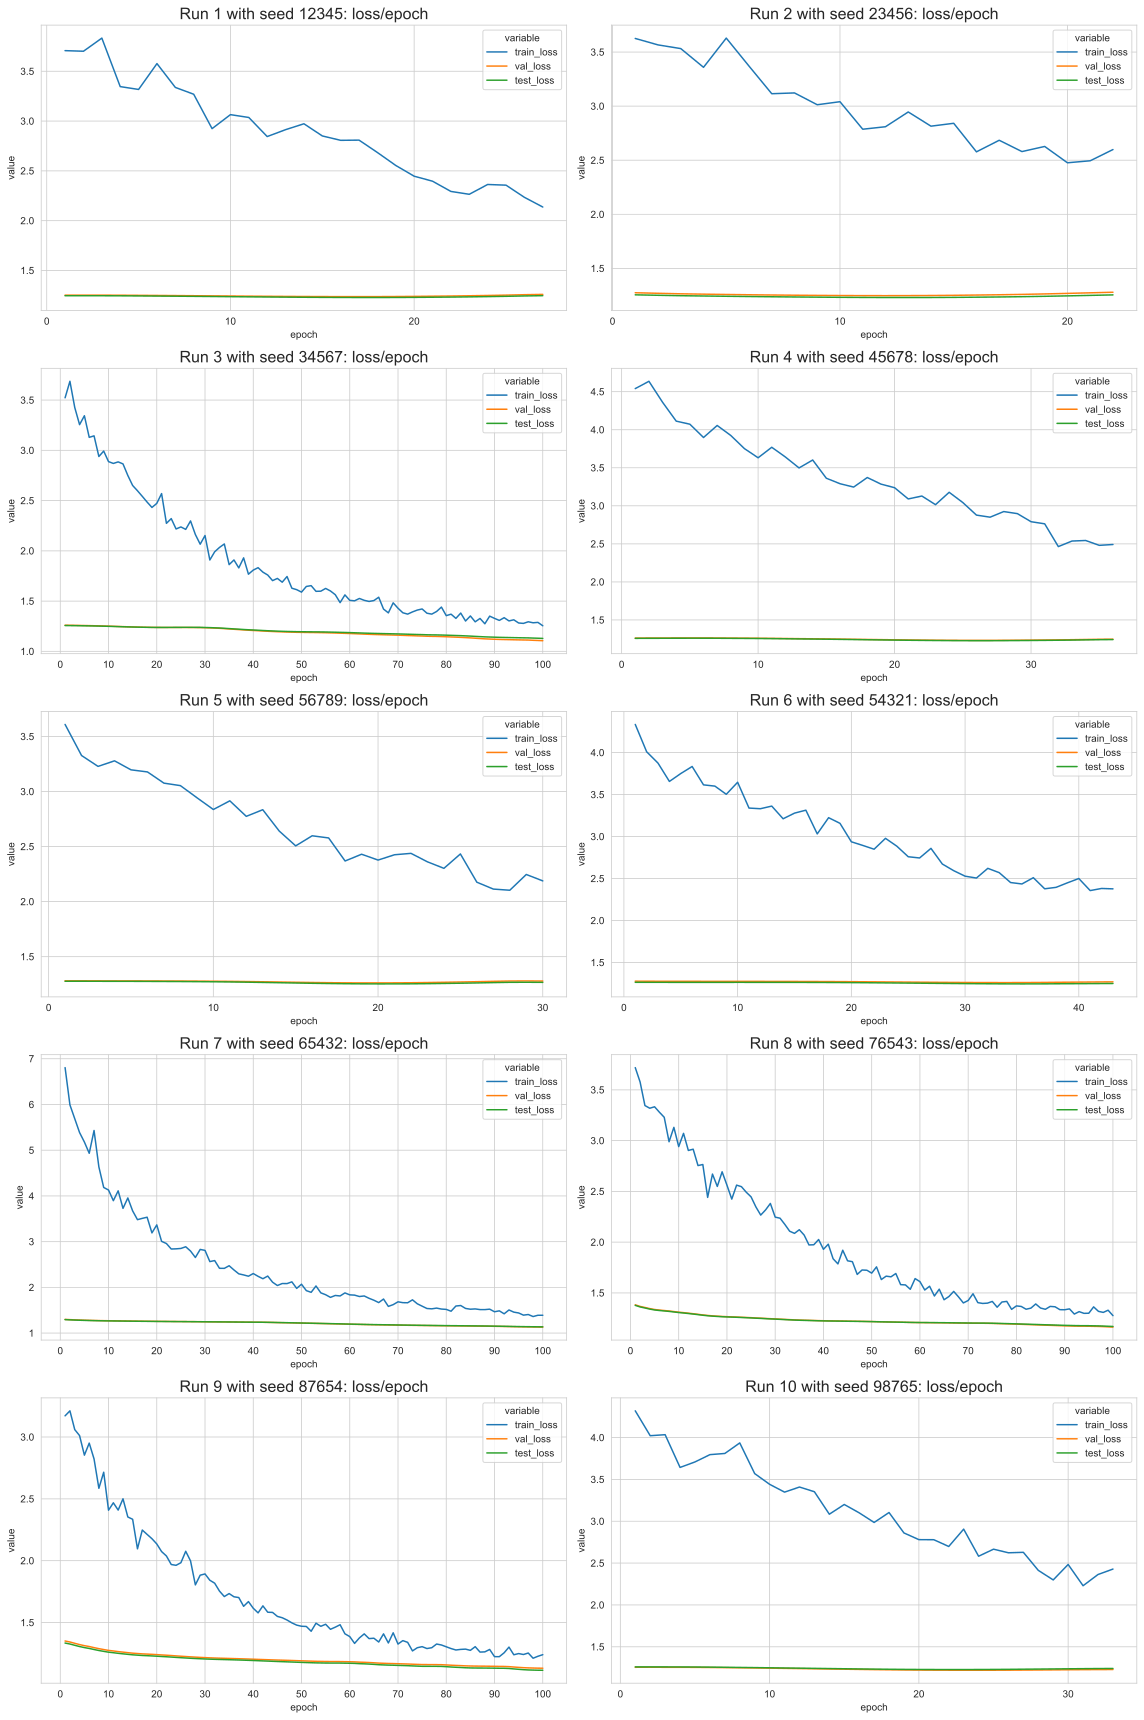

In [16]:
plot_losses_and_accuracies('loss', vgae_results, 404, 10.0, 'vgae_loss', True)

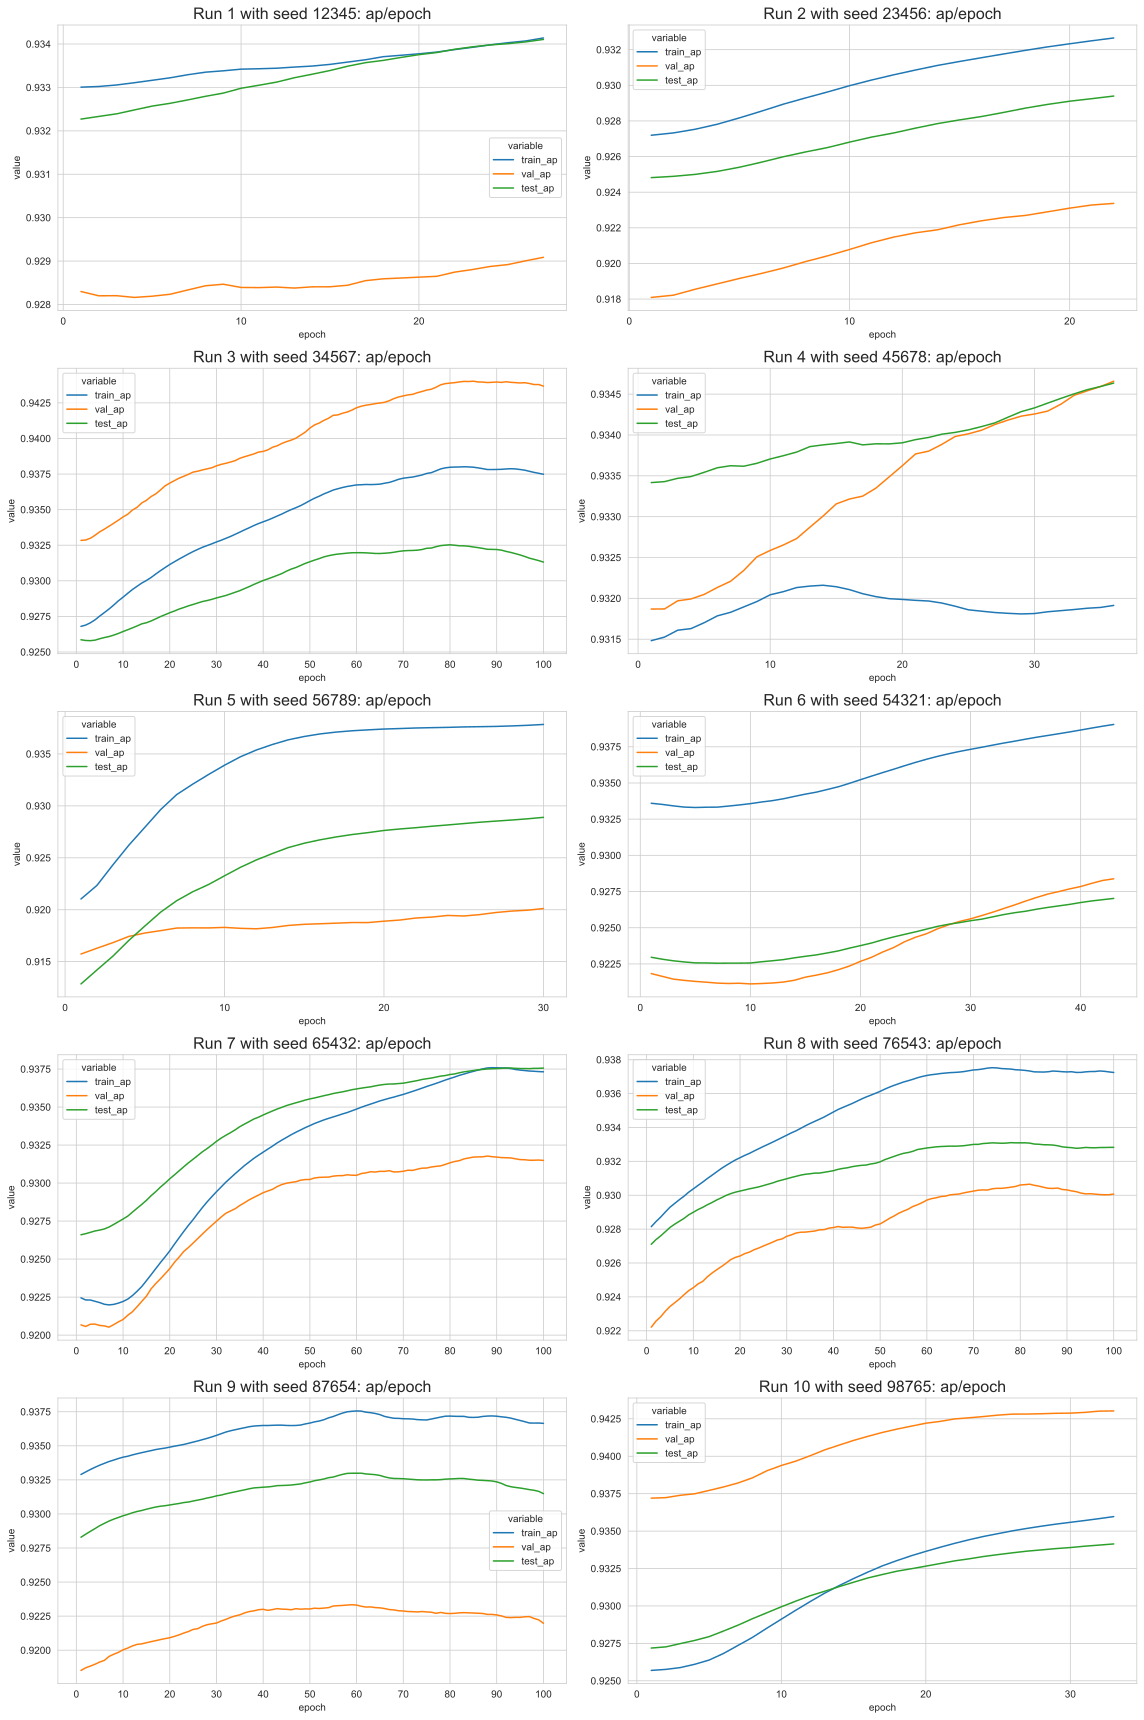

In [17]:
plot_losses_and_accuracies('ap', vgae_results, 404, 10.0, 'vgae_ap', True)

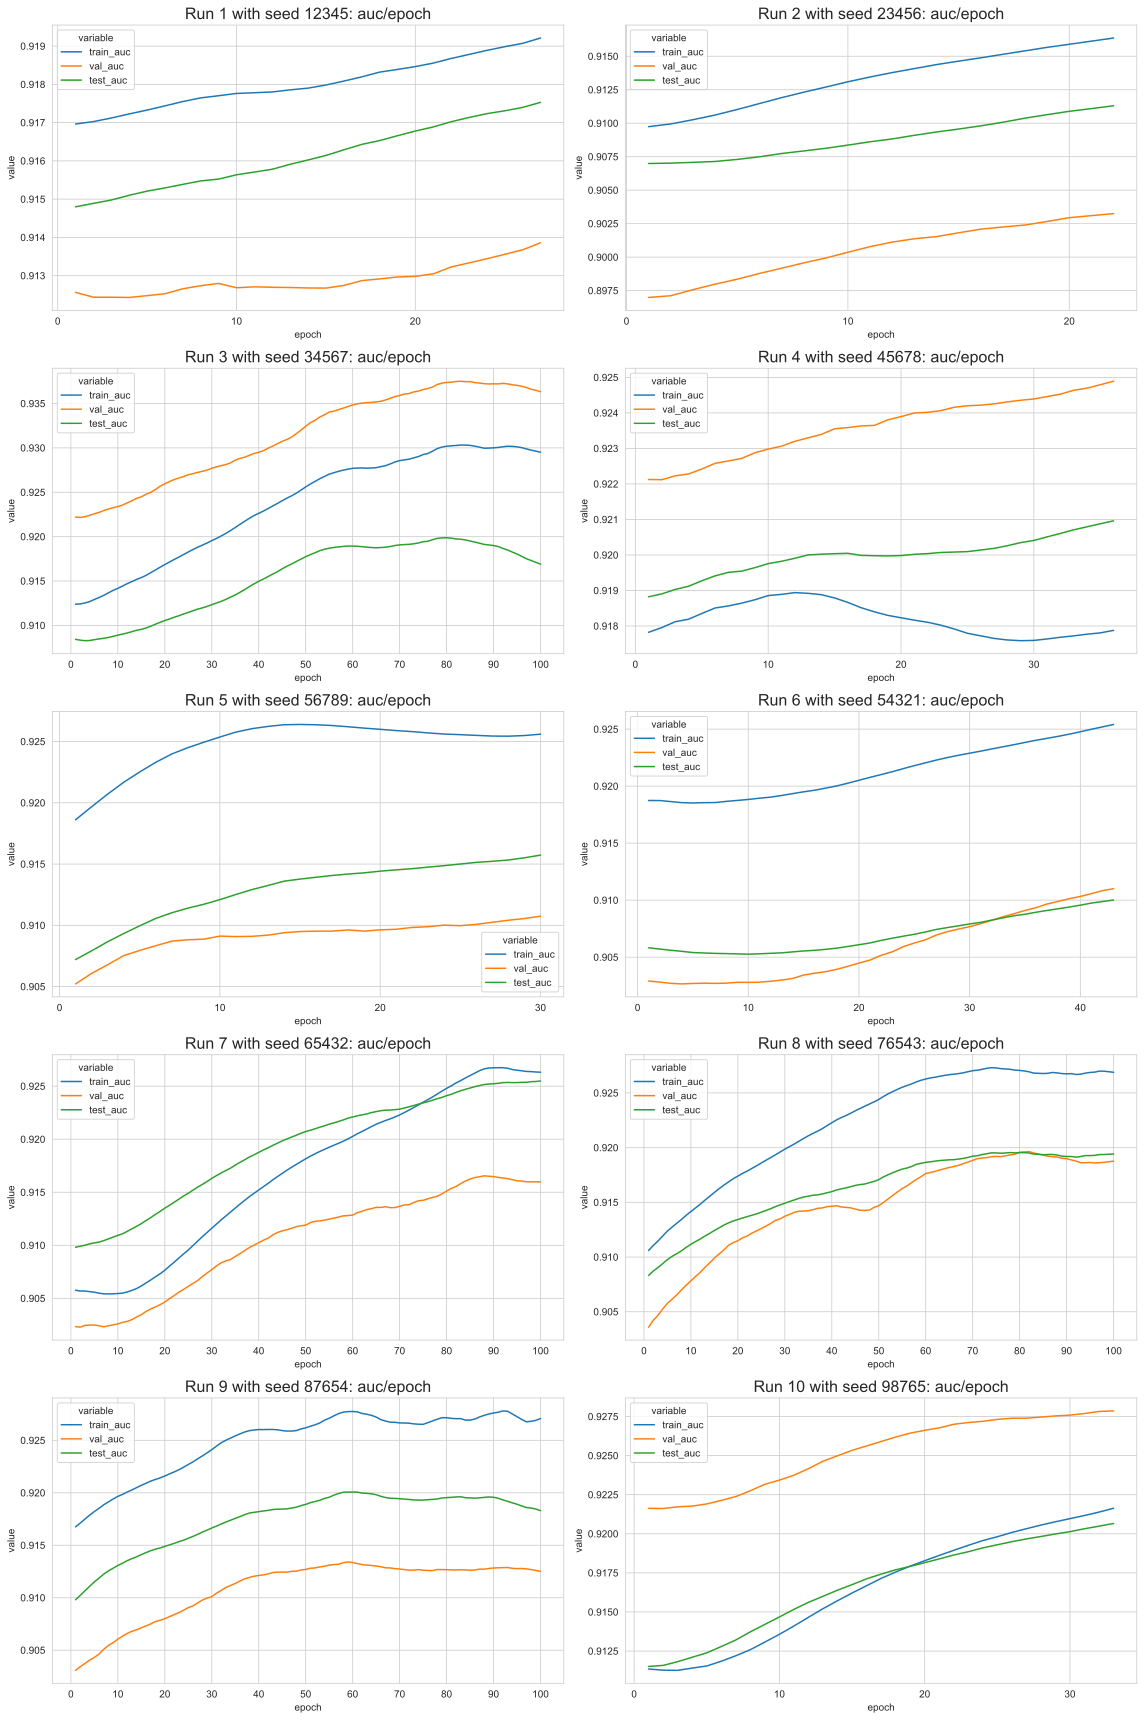

In [18]:
plot_losses_and_accuracies('auc', vgae_results, 404, 10.0, 'vgae_auc', True)